DL Project SimVp

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive')

In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [4]:
class VideoDataset(Dataset):
    def __init__(self, base_path, dataset_type='train', transform=None):
        self.base_path = base_path
        self.dataset_type = dataset_type
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        folder_path = os.path.join(self.base_path, self.dataset_type)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            image_count = 21 if self.dataset_type == 'unlabeled' else 22
            images = [os.path.join(video_path, f'image_{i}.png') for i in range(0, image_count)]
            mask_path = os.path.join(video_path, 'mask.npy') if self.dataset_type != 'unlabeled' else None
            samples.append((images, mask_path))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_paths, mask_path = self.samples[idx]
        images = [Image.open(path) for path in image_paths]

        if self.transform is not None:
            images = [self.transform(image) for image in images]

        images = torch.stack(images)

        if mask_path:
            mask = np.load(mask_path)
            mask = torch.tensor(mask, dtype=torch.long)
        else:
            mask = torch.tensor([])

        return images, mask

In [5]:
# Base path for datasets
base_path = '/content/drive/My Drive/Dataset_Student'  # Adjust this path

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Add any other transformations here
])

In [27]:
train_dataset = VideoDataset(base_path, dataset_type='train', transform=transform)
val_dataset = VideoDataset(base_path, dataset_type='val', transform=transform)
unlabeled_dataset = VideoDataset(base_path, dataset_type='unlabeled', transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

Reference : SimVP - https://github.com/A4Bio/SimVP-Simpler-yet-Better-Video-Prediction/blob/master/modules.py

In [8]:
from torch import nn


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, transpose=False, act_norm=False):
        super(BasicConv2d, self).__init__()
        self.act_norm=act_norm
        if not transpose:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,output_padding=stride //2 )
        self.norm = nn.GroupNorm(2, out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.act(self.norm(y))
        return y


class ConvSC(nn.Module):
    def __init__(self, C_in, C_out, stride, transpose=False, act_norm=True):
        super(ConvSC, self).__init__()
        if stride == 1:
            transpose = False
        self.conv = BasicConv2d(C_in, C_out, kernel_size=3, stride=stride,
                                padding=1, transpose=transpose, act_norm=act_norm)

    def forward(self, x):
        y = self.conv(x)
        return y


class GroupConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups, act_norm=False):
        super(GroupConv2d, self).__init__()
        self.act_norm = act_norm
        if in_channels % groups != 0:
            groups = 1
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,groups=groups)
        self.norm = nn.GroupNorm(groups,out_channels)
        self.activate = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        y = self.conv(x)
        if self.act_norm:
            y = self.activate(self.norm(y))
        return y


class Inception(nn.Module):
    def __init__(self, C_in, C_hid, C_out, incep_ker=[3,5,7,11], groups=8):
        super(Inception, self).__init__()
        self.conv1 = nn.Conv2d(C_in, C_hid, kernel_size=1, stride=1, padding=0)
        layers = []
        for ker in incep_ker:
            layers.append(GroupConv2d(C_hid, C_out, kernel_size=ker, stride=1, padding=ker//2, groups=groups, act_norm=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        y = 0
        for layer in self.layers:
            y += layer(x)
        return y

In [9]:
import torch
from torch import nn


def stride_generator(N, reverse=False):
    strides = [1, 2]*10
    if reverse: return list(reversed(strides[:N]))
    else: return strides[:N]

class Encoder(nn.Module):
    def __init__(self,C_in, C_hid, N_S):
        super(Encoder,self).__init__()
        strides = stride_generator(N_S)
        self.enc = nn.Sequential(
            ConvSC(C_in, C_hid, stride=strides[0]),
            *[ConvSC(C_hid, C_hid, stride=s) for s in strides[1:]]
        )

    def forward(self,x):# B*4, 3, 128, 128
        enc1 = self.enc[0](x)
        latent = enc1
        for i in range(1,len(self.enc)):
            latent = self.enc[i](latent)
        return latent,enc1


class Decoder(nn.Module):
    def __init__(self,C_hid, C_out, N_S):
        super(Decoder,self).__init__()
        strides = stride_generator(N_S, reverse=True)
        self.dec = nn.Sequential(
            *[ConvSC(C_hid, C_hid, stride=s, transpose=True) for s in strides[:-1]],
            ConvSC(2*C_hid, C_hid, stride=strides[-1], transpose=True)
        )
        self.readout = nn.Conv2d(C_hid, C_out, 1)

    def forward(self, hid, enc1=None):
        for i in range(0,len(self.dec)-1):
            hid = self.dec[i](hid)
        Y = self.dec[-1](torch.cat([hid, enc1], dim=1))
        Y = self.readout(Y)
        return Y

class Mid_Xnet(nn.Module):
    def __init__(self, channel_in, channel_hid, N_T, incep_ker = [3,5,7,11], groups=8):
        super(Mid_Xnet, self).__init__()

        self.N_T = N_T
        enc_layers = [Inception(channel_in, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        enc_layers.append(Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))

        dec_layers = [Inception(channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups)]
        for i in range(1, N_T-1):
            dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_hid, incep_ker= incep_ker, groups=groups))
        dec_layers.append(Inception(2*channel_hid, channel_hid//2, channel_in, incep_ker= incep_ker, groups=groups))

        self.enc = nn.Sequential(*enc_layers)
        self.dec = nn.Sequential(*dec_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.reshape(B, T*C, H, W)

        # encoder
        skips = []
        z = x
        for i in range(self.N_T):
            z = self.enc[i](z)
            if i < self.N_T - 1:
                skips.append(z)

        # decoder
        z = self.dec[0](z)
        for i in range(1, self.N_T):
            z = self.dec[i](torch.cat([z, skips[-i]], dim=1))

        y = z.reshape(B, T, C, H, W)
        return y


class SimVP(nn.Module):
    def __init__(self, shape_in, hid_S=16, hid_T=256, N_S=4, N_T=8, incep_ker=[3,5,7,11], groups=8):
        super(SimVP, self).__init__()
        T, C, H, W = shape_in
        self.enc = Encoder(C, hid_S, N_S)
        self.hid = Mid_Xnet(T*hid_S, hid_T, N_T, incep_ker, groups)
        self.dec = Decoder(hid_S, C, N_S)


    def forward(self, x_raw):
        B, T, C, H, W = x_raw.shape
        x = x_raw.reshape(B*T, C, H, W)

        embed, skip = self.enc(x)
        _, C_, H_, W_ = embed.shape

        z = embed.view(B, T, C_, H_, W_)
        hid = self.hid(z)
        hid = hid.reshape(B*T, C_, H_, W_)

        Y = self.dec(hid, skip)
        Y = Y.reshape(B, T, C, H, W)
        return Y

In [10]:
import numpy as np
from skimage.metrics import structural_similarity as cal_ssim

def MAE(pred, true):
    return np.mean(np.abs(pred-true),axis=(0,1)).sum()

def MSE(pred, true):
    return np.mean((pred-true)**2,axis=(0,1)).sum()

# cite the `PSNR` code from E3d-LSTM, Thanks!
# https://github.com/google/e3d_lstm/blob/master/src/trainer.py line 39-40
def PSNR(pred, true):
    mse = np.mean((np.uint8(pred * 255)-np.uint8(true * 255))**2)
    return 20 * np.log10(255) - 10 * np.log10(mse)

def metric(pred, true, mean, std, return_ssim_psnr=False, clip_range=[0, 1]):
    pred = pred*std + mean
    true = true*std + mean
    mae = MAE(pred, true)
    mse = MSE(pred, true)

    if return_ssim_psnr:
        pred = np.maximum(pred, clip_range[0])
        pred = np.minimum(pred, clip_range[1])
        ssim, psnr = 0, 0
        for b in range(pred.shape[0]):
            for f in range(pred.shape[1]):
                ssim += cal_ssim(pred[b, f].swapaxes(0, 2), true[b, f].swapaxes(0, 2), multichannel=True)
                psnr += PSNR(pred[b, f], true[b, f])
        ssim = ssim / (pred.shape[0] * pred.shape[1])
        psnr = psnr / (pred.shape[0] * pred.shape[1])
        return mse, mae, ssim, psnr
    else:
        return mse, mae

In [21]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

epochs=1
shape_in = (11, 3, 128, 128)  # You need to adjust these dimensions based on your actual data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
model = SimVP(shape_in=shape_in).to(device)
model.train()

frame_prediction_criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# OneCycleLR Scheduler
total_steps = epochs * len(train_loader)  # Total number of training steps
scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=total_steps)

for epoch in range(epochs):
    for batch in train_loader:
        images, _ = batch
        input_frames = images[:, :11].to(device)
        target_frame = images[:, 21].to(device)

        # Forward pass
        predicted_frames = model(input_frames)
        predicted_target_frame = predicted_frames[:, -1]

        # Loss computation
        loss = frame_prediction_criterion(predicted_target_frame, target_frame)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the learning rate
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}], Step [{scheduler.last_epoch}/{total_steps}], Loss: {loss.item()}, LR: {scheduler.get_last_lr()[0]}")

Using device: cuda:0
Epoch [1/1], Step [1/250], Loss: 0.32194292545318604, LR: 0.0004043249622175272
Epoch [1/1], Step [2/250], Loss: 0.22402368485927582, LR: 0.0004172920549958721
Epoch [1/1], Step [3/250], Loss: 0.10666711628437042, LR: 0.00043887791075739035
Epoch [1/1], Step [4/250], Loss: 0.06263955682516098, LR: 0.00046904363033099805
Epoch [1/1], Step [5/250], Loss: 0.04304048418998718, LR: 0.0005077348530511047
Epoch [1/1], Step [6/250], Loss: 0.03118308261036873, LR: 0.0005548818547192035
Epoch [1/1], Step [7/250], Loss: 0.02431233413517475, LR: 0.0006103996732515944
Epoch [1/1], Step [8/250], Loss: 0.01989251933991909, LR: 0.0006741882617867945
Epoch [1/1], Step [9/250], Loss: 0.019762611016631126, LR: 0.0007461326689767542
Epoch [1/1], Step [10/250], Loss: 0.019644394516944885, LR: 0.0008261032461369475
Epoch [1/1], Step [11/250], Loss: 0.0239520613104105, LR: 0.0009139558808820714
Epoch [1/1], Step [12/250], Loss: 0.02254207618534565, LR: 0.0010095322568262968
Epoch [1/1], 

In [22]:
model_save_path = 'my_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

# Inform the user
print(f'Model saved to {model_save_path}')

Model saved to my_model.pth


In [23]:
from google.colab import files
files.download(model_save_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import numpy as np

# Replace with the actual path to your .npy file
npy_file = '/Users/devd99/code/DL/final_leaderboard_team_30.npy'
data = np.load(npy_file)

# Get the size and shape of the array
data_size = data.size
data_shape = data.shape

print("Size (total number of elements):", data_size)
print("Shape (dimensions of the array):", data_shape)


Size (total number of elements): 76800000
Shape (dimensions of the array): (2000, 160, 240)


In [26]:
model.eval()
model.to(device)
mse_loss = nn.MSELoss()
total_loss = 0.0
with torch.no_grad():  # Disable gradient computation
    for batch in val_loader:
        images, _ = batch
        input_frames = images[:, :11].to(device)  # First 11 frames
        actual_22nd_frame = images[:, 21].to(device)
        # Forward pass to get the predictions
        predicted_frames = model(input_frames)
        predicted_22nd_frame = predicted_frames[:, -1]
        loss = mse_loss(predicted_22nd_frame, actual_22nd_frame)
        total_loss += loss.item()

# Calculate the average loss
average_loss = total_loss / len(validation_loader)
print(f"Average MSE Loss on the validation dataset: {average_loss}")

KeyboardInterrupt: ignored

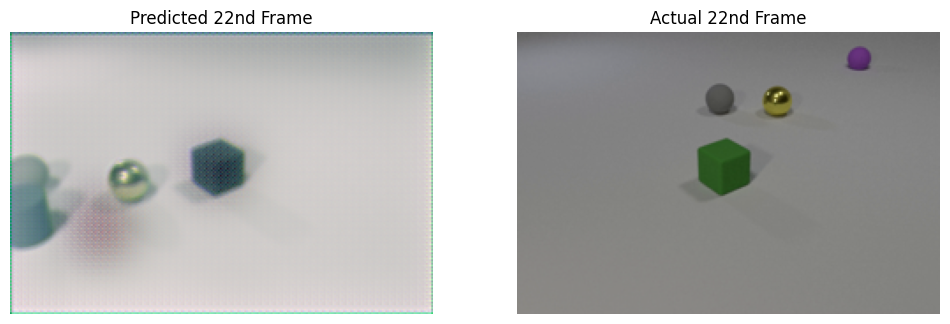

In [28]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

# Assuming the validation DataLoader and the trained model are already defined
# Load one batch from the validation dataset
batch = next(iter(val_loader))
input_frames, _ = batch
input_frames = input_frames.to(device)

# Predict the 22nd frame
model.eval()
with torch.no_grad():
    predicted_frames = model(input_frames[:, :11])  # Use first 11 frames as input
    predicted_22nd_frame = predicted_frames[:, -1]  # Extract the 22nd frame prediction

# Move tensors to CPU for plotting
predicted_22nd_frame = predicted_22nd_frame.cpu()
actual_22nd_frame = input_frames[:, 21].cpu()  # Actual 22nd frame

# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove batch dimension
    tensor = tensor.permute(1, 2, 0)  # Change dimensions from CxHxW to HxWxC
    tensor = tensor.numpy()
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())  # Normalize to [0, 1]
    return tensor

# Convert tensors to images
predicted_image = tensor_to_image(predicted_22nd_frame[0])  # First sample in the batch
actual_image = tensor_to_image(actual_22nd_frame[0])  # First sample in the batch

# Plot the images for comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(predicted_image)
plt.title('Predicted 22nd Frame')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(actual_image)
plt.title('Actual 22nd Frame')
plt.axis('off')

plt.show()
